# Impact of prisons on their surrounding venues

### IBM Capstone Project, Coursera. 

### Author: Mg. Facundo N. Paris

In [6]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors


# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')


from bs4 import BeautifulSoup
import pandas as pd

Libraries imported.


# Prisons location

I use beautifulSoup to analize the '.kml' extension file provided by the web: 

In [7]:
from bs4 import BeautifulSoup

url = "state_pts_AL.kml"

with open(url,'r') as page:
    soup = BeautifulSoup(page, "lxml-xml")
    page.close()
    

# Each 'Row' of data is enclose in 'Placemark', so:    
Rows = soup.find_all('Placemark')

# Lists of the dataframe    
Latitud = []    
Longitud = []
Name = []
Population = []

#Extracting Data for each row
for k in Rows:
    try:
        Name.append(k.find('name').text)
        coord = k.find('coordinates').text
        Latitud.append(float(coord.split(',')[1]))
        Longitud.append(float(coord.split(',')[0]))
        description = k.find('description')
        Popul = (description.find_all('div')[-1].text).split(':')[1]
        try:
            Population.append(int(Popul))
        except ValueError:
            print('No int Population')
            #Delete the last Name, Latitud and Longitud element because there is no population information
            Name.pop()
            Latitud.pop()
            Longitud.pop()
    except AttributeError:
        print("No name...")


No int Population
No int Population
No name...
No int Population
No int Population
No name...
No name...
No int Population
No name...
No int Population
No name...
No name...
No int Population
No name...
No int Population
No name...
No name...
No int Population
No name...
No name...
No int Population
No int Population
No name...
No int Population
No name...


# Construction of the data frame

In [8]:
df_prisons = pd.DataFrame({'Name': Name, 'Population': Population, 'Longitud': Longitud, 'Latitud': Latitud})
df_prisons.head()

,Name,Population,Longitud,Latitud
0,Autauga Metro Jail,181,-86.473973,32.465298
1,Baldwin County Jail,486,-87.774451,30.885110
2,Daphne City Jail,38,-87.892566,30.595724
3,Loxley Community Work Center,505,-87.778375,30.608661
4,Fairhope City Jail,17,-87.902480,30.524892


In [9]:
df_prisons.describe()

,Population,Longitud,Latitud
count,107.000000,107.000000,107.000000
mean,327.887850,-86.673954,32.931015
std,504.519224,0.823900,1.224216
min,1.000000,-88.256741,30.271754
25%,38.000000,-87.299167,32.116878
50%,129.000000,-86.597056,33.246389
75%,326.000000,-86.091740,33.833990
max,2399.000000,-85.017678,34.814631


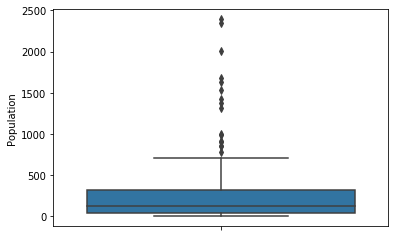

In [10]:
import seaborn as sns
%matplotlib inline
sns.boxplot(y="Population", data=df_prisons)


We keep only the prisons with population bigger than 600 inmates.   

In [11]:
df = df_prisons[df_prisons['Population']>600]

In [12]:
df.describe()

,Population,Longitud,Latitud
count,18.000000,18.000000,18.000000
mean,1296.500000,-86.585069,32.876766
std,547.051697,0.683332,1.125006
min,615.000000,-88.041877,30.681154
25%,869.750000,-87.075408,32.388195
50%,1159.000000,-86.372436,32.757435
75%,1603.000000,-86.158287,33.519553
max,2399.000000,-85.494782,34.811886


# Map of Prisons

In [13]:
address = 'Alabama'
geolocator = Nominatim(user_agent="my-application")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('Alabama: Latitude {} and Longitude {}.'.format(latitude, longitude))

Alabama: Latitude 33.2588817 and Longitude -86.8295337.


In [14]:
# create map of Alabama prisons using latitude and longitude values
map_alabama = folium.Map(location=[latitude, longitude], zoom_start=7)

# add markers to map
for name, lat, lng in zip(df['Name'], df['Latitud'], df['Longitud']):
    label = '{}'.format(name)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_alabama)  
    
map_alabama

# Foursquare Credentials

In [15]:
CLIENT_ID = 'EYQGK0JGIHJQIWJT4LBYPUSIZSLSYOW55R5NVXZHYQRLHTI5' # your Foursquare ID
CLIENT_SECRET = 'N0LWKAMI00YQI2MJ0D5QGEZT15CHFZRRI1VCLDJASNKT3M10' # your Foursquare Secret
VERSION = '20180604'

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: EYQGK0JGIHJQIWJT4LBYPUSIZSLSYOW55R5NVXZHYQRLHTI5
CLIENT_SECRET:N0LWKAMI00YQI2MJ0D5QGEZT15CHFZRRI1VCLDJASNKT3M10


### Lets create a Function that returns the near venues in the prison surroundings. 

In [16]:
def getNearbyVenues(names, latitudes, longitudes, radius=2000, LIMIT=300):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Name', 
                  'Prison Latitude', 
                  'Prison Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [17]:
# Store in a dataFrame

Test_venues = getNearbyVenues(names=df['Name'],
                                   latitudes=df['Latitud'],
                                   longitudes=df['Longitud']
                                  )


Ventress Correctional Facility
Easterling Correctional Facility
Bibb Correctional Facility
Draper / Staton / Elmore prisons
Draper / Staton / Elmore prisons
Tutwiler Prison for Women
Holman Prison
Etowah County Detention Center
Jefferson County Sheriff's Office
Donaldson Correctional Facility
Limestone Correctional Facility
Madison County Main Detention Facility
Mobile County Jail
Montgomery Federal Prison Camp
Kilby Correctional Facility and Montgomery Work Release Center
St. Clair Correctional Facility
Talladega FCI
Tuscaloosa County Jail


Save Test_venues

In [24]:
#Test_venues.to_csv('Test_venues.csv')

We use the save version to avoid use the API again

In [26]:
Test_venues = pd.read_csv('Test_venues.csv',index_col=0)
Test_venues.head()

,Name,Prison Latitude,Prison Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Distance
0,Bibb Correctional Facility,32.925245,-87.164289,Piggly Wiggly,32.937650,-87.165119,Convenience Store,1377.942930
1,Bibb Correctional Facility,32.925245,-87.164289,Bjs Restaurant,32.924740,-87.181952,American Restaurant,1653.008469
2,Draper / Staton / Elmore prisons,32.589624,-86.332650,Scarlett Oak Dr,32.601624,-86.344780,Athletics & Sports,1751.429296
3,Draper / Staton / Elmore prisons,32.589624,-86.332650,The Rogers Farm,32.589363,-86.351538,Scenic Lookout,1773.509217
4,Draper / Staton / Elmore prisons,32.572940,-86.327885,The Spillway,32.568231,-86.342427,River,1461.929914


### Use the geopy distance library to calculate the distance between prisons and venues. 

In [27]:
Dist = []
from geopy import distance
# LATITUDE, LONGITUD
for i in range(len(Test_venues['Name'])):
    Prison_coord = (np.array(Test_venues['Prison Latitude'])[i], np.array(Test_venues['Prison Longitude'])[i])
    Venue_coord = (np.array(Test_venues['Venue Latitude'])[i], np.array(Test_venues['Venue Longitude'])[i])
    dist = distance.distance(Prison_coord, Venue_coord).meters
    Dist.append(dist)

In [28]:
print(len(Dist))
print(len(Test_venues['Name']))

417
417


In [29]:
Test_venues['Distance'] = Dist

In [30]:
Test_venues.head()

,Name,Prison Latitude,Prison Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Distance
0,Bibb Correctional Facility,32.925245,-87.164289,Piggly Wiggly,32.937650,-87.165119,Convenience Store,1377.942930
1,Bibb Correctional Facility,32.925245,-87.164289,Bjs Restaurant,32.924740,-87.181952,American Restaurant,1653.008469
2,Draper / Staton / Elmore prisons,32.589624,-86.332650,Scarlett Oak Dr,32.601624,-86.344780,Athletics & Sports,1751.429296
3,Draper / Staton / Elmore prisons,32.589624,-86.332650,The Rogers Farm,32.589363,-86.351538,Scenic Lookout,1773.509217
4,Draper / Staton / Elmore prisons,32.572940,-86.327885,The Spillway,32.568231,-86.342427,River,1461.929914


### Calculate how many venues are for each prison

In [31]:
Test_venues.groupby('Name').count()

,Prison Latitude,Prison Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Distance
Name,,,,,,,
Bibb Correctional Facility,2,2,2,2,2,2,2
Draper / Staton / Elmore prisons,4,4,4,4,4,4,4
Etowah County Detention Center,42,42,42,42,42,42,42
Holman Prison,1,1,1,1,1,1,1
Jefferson County Sheriff's Office,100,100,100,100,100,100,100
Kilby Correctional Facility and Montgomery Work Release Center,2,2,2,2,2,2,2
Limestone Correctional Facility,1,1,1,1,1,1,1
Madison County Main Detention Facility,100,100,100,100,100,100,100
Mobile County Jail,70,70,70,70,70,70,70


# Histogram of Number of venues vs distance to prison

Lets select Madison County Main Detention Facility:

Text(0.5, 0, 'Meters from Prison')

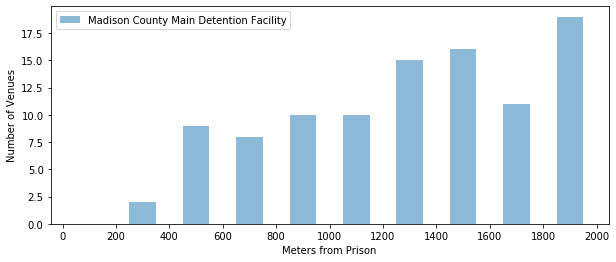

In [32]:
# 'bin_edges' is a list of bin intervals
bin_ed = np.arange(0,2200,200)

Madisonnn = Test_venues[Test_venues['Name']=='Madison County Main Detention Facility']['Distance']
	
hist, bin_edges = np.histogram(Madisonnn, bins = bin_ed)


import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize = (10,4))

ax.set_xticks(bin_ed)

ax.bar(bin_edges[:-1]+100, hist, width = 100,alpha = 0.5,label= 'Madison County Main Detention Facility')

ax.legend(loc='best')

plt.ylabel('Number of Venues') # add y-label
plt.xlabel('Meters from Prison') # add x-label


# Histogram for all the prisons and venues

Text(0.5, 0, 'Meters from Prison')

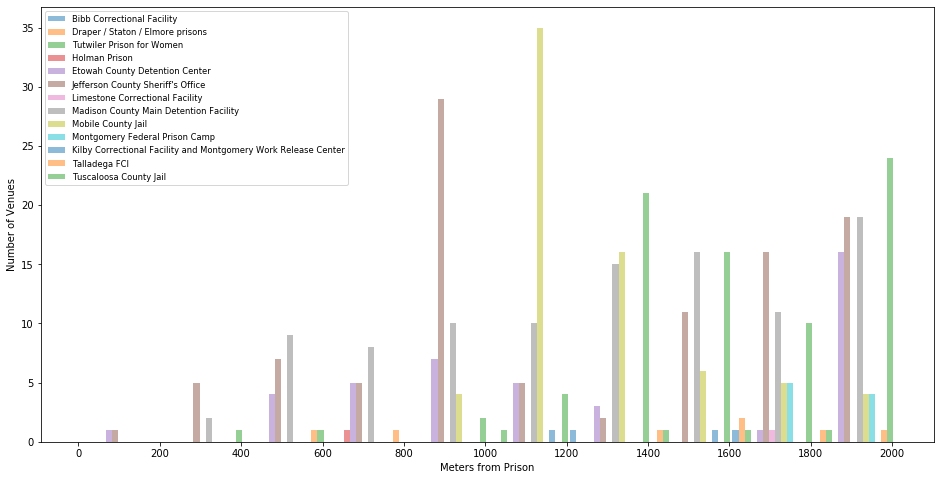

In [33]:
# 'bin_edges' is a list of bin intervals
bin_ed = np.arange(0,2200,200)

fig, ax = plt.subplots(figsize = (16,8))
ax.set_xticks(bin_ed)

width= 0

Avg_Histo = np.zeros(10) # This array is for the Average Histogram
Ranges = [] # This list is to append all the hist lists to create a dataframe to be use to cluster the prisons.

for name in Test_venues['Name'].unique():
    A = Test_venues[Test_venues['Name']==name]['Distance']
    hist, bin_edges = np.histogram(A, bins = bin_ed)
    Ranges.append(hist)
    Avg_Histo = Avg_Histo + hist
    width = width + 15
    ax.bar(bin_edges[:-1] + width, hist, 15,alpha = 0.5,label= name)


Avg_Histo = Avg_Histo/(len(Test_venues['Name'].unique()))   


# Small legend
from matplotlib.font_manager import FontProperties
fontP = FontProperties()
fontP.set_size('small')
#legend([plot1], "title", prop=fontP) 
ax.legend(prop=fontP,loc='best')
#plt.title('H') # add a title to the histogram


plt.ylabel('Number of Venues') # add y-label
plt.xlabel('Meters from Prison') # add x-label

# Histogram of the Average and Regression Plot

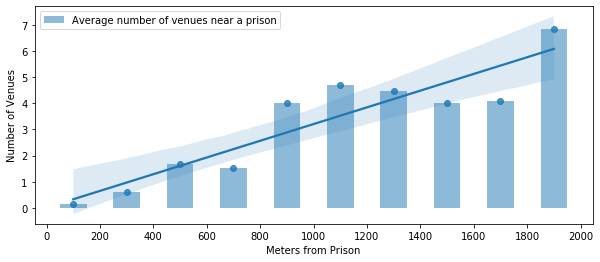

In [34]:
fig, ax1 = plt.subplots(figsize = (10,4))

ax1.bar(bin_edges[:-1] + 100, Avg_Histo, 100,alpha = 0.5,label= 'Average number of venues near a prison')
ax1.set_xticks(bin_ed)
sns.regplot(x=bin_edges[:-1] + 100, y=Avg_Histo)
ax1.legend(loc='upper left')
plt.ylabel('Number of Venues') # add y-label
plt.xlabel('Meters from Prison') # add x-label
plt.show()

# Map of the prisons and venues

In [35]:
for name, lat, lng in zip(Test_venues['Venue'], Test_venues['Venue Latitude'], Test_venues['Venue Longitude']):
    label = '{}'.format(name)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_alabama)  
    
map_alabama

# Cluster of prisons

First, we create a new DataFrame with the Ranges list and the Name of the prisons

In [36]:
df_ranges = pd.DataFrame(Ranges, columns = ['0-200', '200-400','400-600','600-800','800-1000','1000-1200','1200-1400','1400-1600','1600-1800','1800-2000']) 
  

In [37]:
df_ranges['Name'] = Test_venues['Name'].unique()
df_ranges.head()

,0-200,200-400,400-600,600-800,800-1000,1000-1200,1200-1400,1400-1600,1600-1800,1800-2000,Name
0,0,0,0,0,0,0,1,0,1,0,Bibb Correctional Facility
1,0,0,0,0,0,0,0,1,2,1,Draper / Staton / Elmore prisons
2,0,0,0,0,0,1,0,1,1,1,Tutwiler Prison for Women
3,0,0,0,1,0,0,0,0,0,0,Holman Prison
4,1,0,4,5,7,5,3,0,1,16,Etowah County Detention Center


We have to include the prisons that has no venues in their surroundings. We have to identify wich Name is missing in the data frame df_ranges in comparisson with df 

In [38]:
Missing = set(df['Name']).difference(df_ranges['Name'])

Now we have add them to the df_ranges dataframe and fill all the columns with 0. 

In [39]:
List_Zeros = []
Zeroo = np.zeros(10)
for k in range(len(Missing)):
    List_Zeros.append(Zeroo)

# Missing into a List
Miss = []
for i in Missing:
    Miss.append(i)

In [40]:
df_zeros = pd.DataFrame(List_Zeros, columns = ['0-200', '200-400','400-600','600-800','800-1000','1000-1200','1200-1400','1400-1600','1600-1800','1800-2000']) 
df_zeros['Name'] = Miss
df_zeros.head()

,0-200,200-400,400-600,600-800,800-1000,1000-1200,1200-1400,1400-1600,1600-1800,1800-2000,Name
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Easterling Correctional Facility
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,St. Clair Correctional Facility
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Donaldson Correctional Facility
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Ventress Correctional Facility


In [41]:
df_concat = pd.concat([df_zeros,df_ranges])
df_concat.head()

,0-200,200-400,400-600,600-800,800-1000,1000-1200,1200-1400,1400-1600,1600-1800,1800-2000,Name
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Easterling Correctional Facility
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,St. Clair Correctional Facility
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Donaldson Correctional Facility
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Ventress Correctional Facility
0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,Bibb Correctional Facility


In [42]:
# set number of clusters
kclusters = 3

alabama_grouped_clustering = df_concat.drop('Name', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(alabama_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 2], dtype=int32)

In [43]:
# add clustering labels
#df_concat.drop('Cluster Labels', 1,inplace=True)
df_concat.insert(0, 'Cluster Labels', kmeans.labels_)
df_concat.head()

,Cluster Labels,0-200,200-400,400-600,600-800,800-1000,1000-1200,1200-1400,1400-1600,1600-1800,1800-2000,Name
0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Easterling Correctional Facility
1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,St. Clair Correctional Facility
2,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Donaldson Correctional Facility
3,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Ventress Correctional Facility
0,1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,Bibb Correctional Facility


In [44]:
# merge df_concat with df to add latitude/longitude for each neighborhood
df_concat = df_concat.join(df.set_index('Name'), on='Name')

In [45]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=6)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df_concat['Latitud'], df_concat['Longitud'], df_concat['Name'], df_concat['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

# Examine the clusters

### CLUSTER 0

In [46]:
df_concat.loc[df_concat['Cluster Labels'] == 0, df_concat.columns[[1] + list(range(3, df_concat.shape[1]))]]

,0-200,400-600,600-800,800-1000,1000-1200,1200-1400,1400-1600,1600-1800,1800-2000,Name,Population,Longitud,Latitud
8,0.0,0.0,0.0,4.0,35.0,16.0,6.0,5.0,4.0,Mobile County Jail,988,-88.041877,30.681154


### CLUSTER 1

In [47]:
df_concat.loc[df_concat['Cluster Labels'] == 1, df_concat.columns[[1] + list(range(3, df_concat.shape[1]))]]

,0-200,400-600,600-800,800-1000,1000-1200,1200-1400,1400-1600,1600-1800,1800-2000,Name,Population,Longitud,Latitud
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Easterling Correctional Facility,1320,-85.578150,31.675857
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,St. Clair Correctional Facility,1423,-86.375762,33.752715
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Donaldson Correctional Facility,1534,-87.176386,33.508961
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Ventress Correctional Facility,1626,-85.494782,31.888535
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,Bibb Correctional Facility,2007,-87.164289,32.925245
1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,1.0,Draper / Staton / Elmore prisons,1376,-86.332650,32.589624
1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,1.0,Draper / Staton / Elmore prisons,2399,-86.327885,32.572940
2,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,Tutwiler Prison for Women,711,-86.193812,32.565857
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,Holman Prison,998,-87.442621,31.133766
4,1.0,4.0,5.0,7.0,5.0,3.0,0.0,1.0,16.0,Etowah County Detention Center,784,-86.012089,34.016408


Cluster 1 seems to be the facilities with almost zero venues in the surroundings.

### CLUSTER 2

In [48]:
df_concat.loc[df_concat['Cluster Labels'] == 2, df_concat.columns[[1] + list(range(3, df_concat.shape[1]))]]

,0-200,400-600,600-800,800-1000,1000-1200,1200-1400,1400-1600,1600-1800,1800-2000,Name,Population,Longitud,Latitud
5,1.0,7.0,5.0,29.0,5.0,2.0,11.0,16.0,19.0,Jefferson County Sheriff's Office,905,-86.808764,33.523083
7,0.0,9.0,8.0,10.0,10.0,15.0,16.0,11.0,19.0,Madison County Main Detention Facility,858,-86.597056,34.737610
12,0.0,1.0,0.0,2.0,4.0,21.0,16.0,10.0,24.0,Tuscaloosa County Jail,615,-87.567209,33.198246
